In [53]:
import os
from rosemary import jpt_setup; jpt_setup()
from rosemary import plt_scaled_colobar_ax

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from llm.evaluate import get_eval_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
instruct_datasets = ['cot', 'flan_v2', 'dolly', 'oasst1']
eval_metrics = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1']


In [76]:
## llama-7b instruction tuned on different mixes.

use_relative_gain = True
total_train_samples = 200000
model_name_contain = 'llama-7b'

ft_args_fields = [
    'run_name',
    'model_args.model_name_or_path',
    'data_args.subsample_mixture',
]

exp_dir = '../results/ft2'
save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/')]
save_dirs += [(os.path.basename(x), x) for x in 
              [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
save_dirs = filter(lambda x: 'withreplacement' not in x[1], save_dirs)

df = get_eval_results(save_dirs, chat_fmt=True, ft_args_fields=ft_args_fields)
df = df[ft_args_fields+eval_metrics]

dfc = df.copy()
dfc.insert(0, 'total_train_samples',  dfc['data_args.subsample_mixture'].apply(
    lambda d: sum(list(d.values())) if d else 200000))
dfc = dfc[dfc['total_train_samples'].apply(
    lambda x: total_train_samples-20000<x<total_train_samples+20000)]
dfc = dfc[dfc['model_args.model_name_or_path'].apply(
    lambda x: model_name_contain in x)]
dfc['total_train_samples'] = dfc['total_train_samples'].astype(str)
dfc = dfc.reset_index(drop=True)

# base model
dfc.at[0,  'data_args.subsample_mixture'] = {'cot': 0, 'dolly': 0, 'flan_v2': 0, 'oasst1': 0}

def compute_mixture_proportion_fn(d):
    s = sum(list(d.values()))
    L = []
    for x in instruct_datasets:
        L.append(d[x]/s if s>0 else 0)
    return L
        
dfc['x'] = dfc['data_args.subsample_mixture'].apply(compute_mixture_proportion_fn)
dfc['y'] = dfc.apply(lambda row: np.array([row[x] for x in eval_metrics]), axis=1)
if use_relative_gain:
    base_model_ind = 0
    base_model_perf = dfc.loc[base_model_ind,'y']
    dfc['y'] = dfc['y'].apply(lambda x: x - base_model_perf).to_list()
    dfc = dfc.drop(base_model_ind)
    dfc.reset_index(inplace=True, drop=True)
dfc

,total_train_samples,run_name,model_args.model_name_or_path,data_args.subsample_mixture,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,x,y
0,199997,"llama-7b_all:200k_mix=cot:46128,dolly:9386,fla...",results/baselines/huggyllama/llama-7b,"{'cot': 46128, 'dolly': 9386, 'flan_v2': 14424...",43.904002,46.368039,5.0,17.0,36.159018,32.037037,10.154029,45.712140,4.268293,"[0.23064345965189478, 0.7212258183872758, 0.04...","[11.444238712434128, 13.31006979062812, -0.5, ..."
1,199999,"llama-7b_all:200k_mix=cot:22489,dolly:43994,fl...",results/baselines/huggyllama/llama-7b,"{'cot': 22489, 'dolly': 43994, 'flan_v2': 1165...",43.255946,45.150263,4.5,15.0,36.486059,31.388889,9.694981,38.651060,3.048780,"[0.11244556222781114, 0.5826679133395667, 0.21...","[10.796182879931635, 12.092294544936621, -1.0,..."
2,199999,"llama-7b_all:200k_mix=cot:27757,dolly:11372,fl...",results/baselines/huggyllama/llama-7b,"{'cot': 27757, 'dolly': 11372, 'flan_v2': 1340...",41.995442,44.288563,4.5,19.5,37.408689,32.129630,9.035500,44.361642,0.609756,"[0.13878569392846965, 0.6701383506917534, 0.05...","[9.53567867825096, 11.230593932488254, -1.0, 8..."
3,199999,"llama-7b_all:200k_mix=cot:55409,dolly:114245,f...",results/baselines/huggyllama/llama-7b,"{'cot': 55409, 'dolly': 114245, 'flan_v2': 498...",28.364905,28.649765,6.0,19.5,35.042380,32.500000,10.696907,40.504711,0.000000,"[0.27704638523192615, 0.024940124700623505, 0....","[-4.09485828229597, -4.408203959549919, 0.5, 8..."
4,199998,"llama-7b_all:200k_mix=cot:44759,dolly:61131,fl...",results/baselines/huggyllama/llama-7b,"{'cot': 44759, 'dolly': 61131, 'flan_v2': 3091...",38.406210,38.541518,5.5,22.5,34.556323,31.759259,10.890047,46.566055,1.219512,"[0.22379723797237971, 0.15457654576545765, 0.3...","[5.946446375160228, 5.48354935194417, 0.0, 11...."
5,200000,"llama-7b_all:200k_mix=cot:50000,dolly:50000,fl...",results/baselines/huggyllama/llama-7b,"{'cot': 50000, 'dolly': 50000, 'flan_v2': 5000...",34.076342,38.883350,5.0,19.5,33.958081,33.148148,9.999042,42.187476,1.219512,"[0.25, 0.25, 0.25, 0.25]","[1.6165788349238, 5.825380999857572, -0.5, 8.5..."
6,199998,"llama-7b_all:200k_mix=cot:27136,dolly:11929,fl...",results/baselines/huggyllama/llama-7b,"{'cot': 27136, 'dolly': 11929, 'flan_v2': 7915...",42.472582,42.508190,4.0,15.5,35.848182,33.703704,10.264019,44.080953,0.000000,"[0.13568135681356813, 0.3957789577895779, 0.05...","[10.012818686796756, 9.450220766272615, -1.5, ..."
7,211155,"llama-7b_all:200k_mix=cot:6323,dolly:40966,fla...",results/baselines/huggyllama/llama-7b,"{'cot': 6323, 'dolly': 40966, 'flan_v2': 81933...",40.044153,41.895741,7.5,18.5,35.279586,30.277778,10.255578,41.282352,0.000000,"[0.029944827259596032, 0.38802301626767066, 0....","[7.584389688078616, 8.837772397094433, 2.0, 7...."
8,199998,"llama-7b_all:200k_mix=cot:16131,dolly:83772,fl...",results/baselines/huggyllama/llama-7b,"{'cot': 16131, 'dolly': 83772, 'flan_v2': 4344...",39.196696,37.971799,5.0,17.0,34.468655,32.407407,10.517109,44.297010,0.000000,"[0.08065580655806558, 0.2172371723717237, 0.41...","[6.73693206095998, 4.913829938755164, -0.5, 6...."
9,199998,"llama-7b_all:200k_mix=cot:49222,dolly:19548,fl...",results/baselines/huggyllama/llama-7b,"{'cot': 49222, 'dolly': 19548, 'flan_v2': 2794...",31.761857,33.805726,5.0,23.0,34.887414,30.000000,9.084395,40.839934,0.000000,"[0.24611246112461124, 0.13974139741397415, 0.0...","[-0.6979062811565271, 0.7477567298105683, -0.5..."


In [73]:
X

array([[0.23064346, 0.72122582, 0.0469307 , 0.00120002],
       [0.11244556, 0.58266791, 0.2199711 , 0.08491542],
       [0.13878569, 0.67013835, 0.05686028, 0.13421567],
       [0.27704639, 0.02494012, 0.57122786, 0.12678563],
       [0.22379724, 0.15457655, 0.30565806, 0.31596816],
       [0.25      , 0.25      , 0.25      , 0.25      ],
       [0.13568136, 0.39577896, 0.0596456 , 0.40889409],
       [0.02994483, 0.38802302, 0.19400914, 0.38802302],
       [0.08065581, 0.21723717, 0.41886419, 0.28324283],
       [0.24611246, 0.1397414 , 0.09774098, 0.51640516],
       [0.07647258, 0.91004163, 0.0044521 , 0.00903368],
       [0.00245002, 0.01226512, 0.13274633, 0.85253853],
       [0.37664377, 0.39740897, 0.08746087, 0.13848638],
       [0.08677324, 0.35254478, 0.55021407, 0.01046791],
       [0.40697907, 0.09504595, 0.06318563, 0.43478935],
       [0.18234182, 0.32706327, 0.16353164, 0.32706327],
       [0.48785488, 0.48785488, 0.00732007, 0.01697017]])

In [74]:
X = np.array(dfc['x'].to_list())
Y = np.array(dfc['y'].to_list())

print('X.shape & Y.shape: ', X.shape, Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

X_train

X.shape & Y.shape:  (17, 4) (17, 9)
(13, 4) (4, 4) (13, 9) (4, 9)


array([[0.00245002, 0.01226512, 0.13274633, 0.85253853],
       [0.40697907, 0.09504595, 0.06318563, 0.43478935],
       [0.08065581, 0.21723717, 0.41886419, 0.28324283],
       [0.08677324, 0.35254478, 0.55021407, 0.01046791],
       [0.13878569, 0.67013835, 0.05686028, 0.13421567],
       [0.24611246, 0.1397414 , 0.09774098, 0.51640516],
       [0.48785488, 0.48785488, 0.00732007, 0.01697017],
       [0.22379724, 0.15457655, 0.30565806, 0.31596816],
       [0.02994483, 0.38802302, 0.19400914, 0.38802302],
       [0.07647258, 0.91004163, 0.0044521 , 0.00903368],
       [0.37664377, 0.39740897, 0.08746087, 0.13848638],
       [0.27704639, 0.02494012, 0.57122786, 0.12678563],
       [0.13568136, 0.39577896, 0.0596456 , 0.40889409]])

In [97]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, ElasticNet, Lasso
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

reg = MultiOutputRegressor(ElasticNet(
    random_state=123, 
    fit_intercept=True,
    # alpha=.01, l1_ratio=.5,
    alpha=.1, l1_ratio=.5,
#     alpha = .1, l1_ratio=1,
))
reg.fit(X_train, Y_train)
# reg.fit(X, Y)


Y_pred = reg.predict(X_test)
print(f'MSE: {sklearn.metrics.mean_squared_error(Y_test, Y_pred):.2f}')

reg

MSE: 3.57


MultiOutputRegressor(estimator=ElasticNet(alpha=0.1, random_state=123))

In [94]:
W = np.stack([reg.estimators_[i].coef_ for i in range(len(reg.estimators_))]).T
b = np.stack([reg.estimators_[i].intercept_ for i in range(len(reg.estimators_))]).T

with np.printoptions(precision=2, suppress=True):
    print(W.shape, b.shape)
    print(W)
    print('intersept:  ', b)
    print('base model: ', base_model_perf)

(4, 9) (9,)
[[-0.04 -0.   -0.    6.89  0.    1.3   0.   -0.    0.5 ]
 [ 5.65  6.82 -0.46 -1.93  1.71  0.   -0.21  1.55  0.11]
 [-2.73 -3.56  0.58 -1.94 -0.01 -0.    0.   -0.   -0.44]
 [-0.88 -1.58  0.   -1.03 -0.91 -1.4   0.   -1.33 -0.17]]
intersept:   [ 5.64  5.97 -0.12  8.13  2.01  3.41 -0.04  3.89  0.7 ]
base model:  [32.46 33.06  5.5  11.   32.97 28.43 10.35 38.56  0.  ]


<Axes: xlabel='Output', ylabel='Input'>

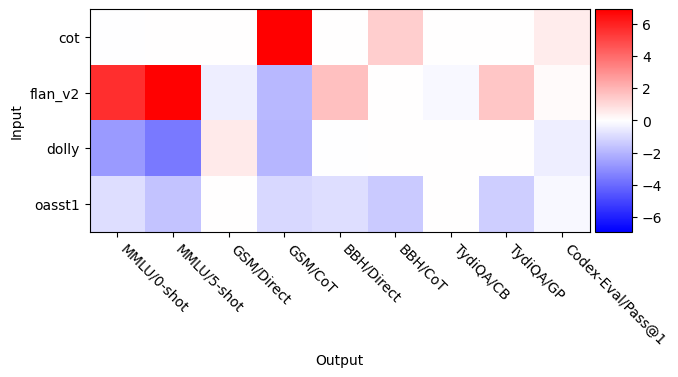

In [98]:
fig, ax = plt.subplots(1,1,figsize=(7,10))
v = max(abs(W.max()), abs(W.min()))
im = ax.imshow(W, cmap='bwr', vmin=-v, vmax=v)
fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
ax.set_ylabel('Input')
ax.set_xlabel('Output')
ax.set_yticks(list(range(len(instruct_datasets))), instruct_datasets)
ax.set_xticks(list(range(len(eval_metrics))), eval_metrics, rotation=-45, ha='left')
ax

In [121]:
x = np.arange(0, 1+.1, .1)
X_grid = np.meshgrid(x,x,x,x)
X_grid = np.hstack([x.reshape(-1,1) for x in X_grid])
print(X_grid.shape)

Y_grid = reg.predict(X_grid)

(14641, 4)


In [141]:
Y_avg = Y_grid.mean(-1)

# find topk values
k = 10
ind = np.argsort(Y_avg)[-k:][::-1]
print(ind)

print(X_grid[ind])
print(Y_avg[ind])

[14520 14521 14531 14399 13189 14522 14532 14400 14542 14410]
[[1.  1.  0.  0. ]
 [1.  1.  0.  0.1]
 [1.  1.  0.1 0. ]
 [0.9 1.  0.  0. ]
 [1.  0.9 0.  0. ]
 [1.  1.  0.  0.2]
 [1.  1.  0.1 0.1]
 [0.9 1.  0.  0.1]
 [1.  1.  0.2 0. ]
 [0.9 1.  0.1 0. ]]
[5.72265013 5.64145547 5.6325993  5.62657211 5.57539045 5.5602608
 5.55140463 5.54537744 5.54254846 5.53652127]


In [142]:
Y_avg = Y_grid[:,[0,3,4,7]].mean(-1)

# find topk values
k = 10
ind = np.argsort(Y_avg)[-k:][::-1]
print(ind)

print(X_grid[ind])
print(Y_avg[ind])

[14520 14521 14531 14399 13189 14522 14532 14542 14400 13190]
[[1.  1.  0.  0. ]
 [1.  1.  0.  0.1]
 [1.  1.  0.1 0. ]
 [0.9 1.  0.  0. ]
 [1.  0.9 0.  0. ]
 [1.  1.  0.  0.2]
 [1.  1.  0.1 0.1]
 [1.  1.  0.2 0. ]
 [0.9 1.  0.  0.1]
 [1.  0.9 0.  0.1]]
[8.37963434 8.27586657 8.26247753 8.20829235 8.20488413 8.1720988
 8.15870976 8.14532072 8.10452458 8.10111636]
